In [3]:
import requests
import pandas as pd

def search_taxon(name):
    url = f"https://api.obis.org/v3/taxon/complete/{name}"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()
    return pd.DataFrame(data)   # <-- no ["results"] here

# Search for jellyfish (Scyphozoa)
df_taxon = search_taxon("Scyphozoa")
print(df_taxon.head(10))


        id            scientificName acceptedNameUsageID  \
0   135220                 Scyphozoa              135220   
1  1561414  Scyphozoa incertae sedis             1561414   

  scientificNameAuthorship      rank   kingdom    phylum      class order  \
0             Goette, 1887     Class  Animalia  Cnidaria  Scyphozoa  None   
1                     None  Subclass  Animalia  Cnidaria  Scyphozoa  None   

  family genus species  
0   None  None    None  
1   None  None    None  


In [5]:
import requests
import pandas as pd
import numpy as np

def get_obis_occurrences(taxonid, size=10000, limit=50000):
    """Fetch OBIS occurrence records for a given taxonID"""
    url = f"https://api.obis.org/v3/occurrence?taxonid={taxonid}&size={size}"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json().get("results", [])
    return pd.DataFrame(data)

def bin_grid(df, lat_col="decimalLatitude", lon_col="decimalLongitude"):
    """Bin lat/lon occurrences into 1° grid"""
    if lat_col in df and lon_col in df:
        return (
            df.groupby([df[lat_col].round(), df[lon_col].round()])
              .size()
              .reset_index(name="count")
              .rename(columns={lat_col: "lat", lon_col: "lon"})
        )
    return pd.DataFrame(columns=["lat","lon","count"])


In [6]:
# Copepods (1080)
df_copepods = get_obis_occurrences(1080)
grid_copepods = bin_grid(df_copepods)

# Jellyfish (Scyphozoa, 135220)
df_jelly = get_obis_occurrences(135220)
grid_jelly = bin_grid(df_jelly)

print("Copepods grid:", grid_copepods.shape)
print("Jellyfish grid:", grid_jelly.shape)


Copepods grid: (2767, 3)
Jellyfish grid: (1553, 3)


In [10]:
import pandas as pd
import gzip

fname = "woa18_decav_s00mn01.csv.gz"

# Read as fixed-width inside gzip
with gzip.open(fname, "rt") as f:
    df_raw = pd.read_fwf(f, comment="#", header=None)

print("Raw shape:", df_raw.shape)
print(df_raw.head())


Raw shape: (40193, 1)
                                                   0
0  -77.500,-178.500,34.191,34.172,34.174,34.203,3...
1  -77.500,-177.500,34.133,34.129,34.128,34.133,3...
2  -77.500,-176.500,34.192,34.200,34.214,34.234,3...
3  -77.500,-175.500,34.232,34.232,34.245,34.254,3...
4  -77.500,-174.500,34.185,34.187,34.244,34.303,3...


In [15]:
import pandas as pd
import numpy as np
import gzip

fname = "../data/woa18_decav_s00mn01.csv.gz"

# Read file and split lines safely
with gzip.open(fname, "rt") as f:
    lines = [line.strip() for line in f if not line.startswith("#")]

# Split by commas, skip empty strings, convert to float
rows = []
for line in lines:
    parts = [p for p in line.split(",") if p != ""]
    rows.append(list(map(float, parts)))

# Convert to DataFrame
df_raw = pd.DataFrame(rows)
print("Raw shape:", df_raw.shape)
print(df_raw.head())


Raw shape: (40193, 104)
    0      1       2       3       4       5       6       7       8    \
0 -77.5 -178.5  34.191  34.172  34.174  34.203  34.220  34.235  34.242   
1 -77.5 -177.5  34.133  34.129  34.128  34.133  34.138  34.165  34.184   
2 -77.5 -176.5  34.192  34.200  34.214  34.234  34.259  34.266  34.269   
3 -77.5 -175.5  34.232  34.232  34.245  34.254  34.259  34.270  34.289   
4 -77.5 -174.5  34.185  34.187  34.244  34.303  34.332  34.339  34.343   

      9    ...  94   95   96   97   98   99   100  101  102  103  
0  34.251  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1  34.227  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  34.275  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3  34.346  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4  34.353  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 104 columns]


In [16]:
lats = df_raw.iloc[:, 0].values   # latitude
lons = df_raw.iloc[:, 1].values   # longitude
sal  = df_raw.iloc[:, 2].values   # surface salinity

df_sal = pd.DataFrame({
    "lat_bin": lats,
    "lon_bin": lons,
    "salinity": sal
}).dropna()

print(df_sal.head())
print("Salinity tidy shape:", df_sal.shape)


   lat_bin  lon_bin  salinity
0    -77.5   -178.5    34.191
1    -77.5   -177.5    34.133
2    -77.5   -176.5    34.192
3    -77.5   -175.5    34.232
4    -77.5   -174.5    34.185
Salinity tidy shape: (40193, 3)


In [21]:
def bin_grid(df, cellsize=1):
    if "decimalLatitude" not in df.columns or "decimalLongitude" not in df.columns:
        return pd.DataFrame()

    df = df.copy()
    df["lat_bin"] = (df["decimalLatitude"].round() - 0.5).astype(float)
    df["lon_bin"] = (df["decimalLongitude"].round() - 0.5).astype(float)

    return (df.groupby(["lat_bin", "lon_bin"])
              .size()
              .reset_index(name="count"))


In [22]:
grid_copepods = bin_grid(df_copepods)
grid_jelly    = bin_grid(df_jelly)

merged = df_sal.merge(grid_copepods, on=["lat_bin", "lon_bin"], how="inner", suffixes=("", "_copepods"))
merged = merged.merge(grid_jelly, on=["lat_bin", "lon_bin"], how="inner", suffixes=("", "_jelly"))

merged = merged.rename(columns={"count": "copepods", "count_jelly": "jellyfish"})
print(merged.shape)
print(merged.head())


(380, 5)
   lat_bin  lon_bin  salinity  copepods  jellyfish
0    -58.5    -77.5    34.103         1          1
1    -57.5    -64.5    34.020         1          1
2    -53.5    116.5    33.854         1          1
3    -53.5    172.5    34.292         2          1
4    -50.5     69.5    33.863         2          1


In [23]:
# Pearson correlation
print(merged[["salinity", "copepods", "jellyfish"]].corr())

# Or Spearman rank (if distributions are not normal)
print(merged[["salinity", "copepods", "jellyfish"]].corr(method="spearman"))


           salinity  copepods  jellyfish
salinity   1.000000 -0.077595  -0.019528
copepods  -0.077595  1.000000   0.025267
jellyfish -0.019528  0.025267   1.000000
           salinity  copepods  jellyfish
salinity   1.000000 -0.037812  -0.113895
copepods  -0.037812  1.000000   0.271125
jellyfish -0.113895  0.271125   1.000000


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Compute Pearson correlation matrix ---
pearson_corr = merged[["salinity", "copepods", "jellyfish"]].corr(method="pearson")

plt.figure(figsize=(6,4))
sns.heatmap(
    pearson_corr,
    annot=True, fmt=".3f", cmap="coolwarm", center=0,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Heatmap (Pearson)")
plt.show()


NameError: name 'merged' is not defined

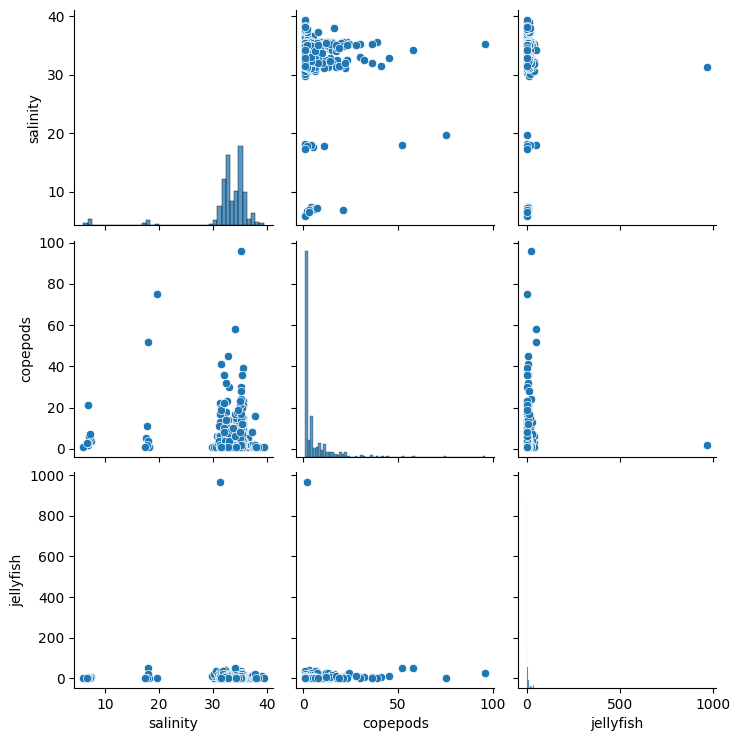

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(merged[["salinity", "copepods", "jellyfish"]], kind="scatter")
plt.show()


## This tells us:

### Salinity doesn’t strongly explain copepod or jellyfish abundance in your gridded dataset.

### Jellyfish and copepods don’t show much correlation with each other either.

### Spearman reveals slightly stronger monotonic relationships than Pearson, which makes sense given the non-normal distributions you saw in the scatterplots (lots of zeros + long tails).

## carbon (TCO₂)